In [1]:
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from transformers import AdamW, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments, AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import T5Tokenizer, T5ForConditionalGeneration


import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

from tqdm.auto import tqdm

from nltk.translate.bleu_score import corpus_bleu, sentence_bleu

import re

In [3]:
data_file_open = open("data_f.txt", 'r', encoding='UTF-8')
label_file_open = open("label_f.txt", 'r', encoding='UTF-8')
data_lines=data_file_open.readlines()
label_lines = label_file_open.readlines()

input_dataset = []
output_dataset = []
dataset = []


for item in data_lines:
    input_dataset.append(item.strip())
for item in label_lines:
    output_dataset.append(item.strip())

In [4]:
print(len(input_dataset))
print(len(output_dataset))

42535
42535


In [5]:
num = 0

for i in range(len(input_dataset)):
    if len(input_dataset[i].split())>20:
        num+=1

    if len(output_dataset[i].split())>20:
        num=num
print(num)

2693


In [6]:
final_input = []
final_output = []

for i in range(len(input_dataset)):
    if (len(input_dataset[i].split())>20 or len(output_dataset[i].split())>20):
        continue
    else:
        final_input.append(input_dataset[i])
        final_output.append(output_dataset[i])

In [7]:
print(len(final_input))
print(len(final_output))

39442
39442


In [8]:
print(final_input[0])
print(final_output[0])

Now, beautiful Hippolyta , the hour of our wedding is speeding closer.
Now, fair Hippolyta, our nuptial hour Draws on apace.


In [9]:
tokenizer = T5Tokenizer.from_pretrained("t5-small")
#model = AutoModelWithLMHead.from_pretrained("t5-small", pad_token_id=tokenizer.eos_token_id)
model = T5ForConditionalGeneration.from_pretrained("t5-small")

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:174: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [10]:
class ShakespeareDataset(Dataset):

    def __init__(self, encodings_data, encoding_label):
        self.encodings_data = encodings_data
        self.encoding_label = encoding_label
        
    def __getitem__(self, index):
        x = {key: torch.tensor(val[index]) for key,val in self.encodings_data.items()}
        y = {key: torch.tensor(val[index]) for key,val in self.encoding_label.items()}
        return_map={"x": x, "y": y}
        return return_map

    def __len__(self):
        return len(self.encodings_data['input_ids'])

In [11]:
train_dataset = ShakespeareDataset(tokenizer(final_input[:35000], truncation=True, padding=True), tokenizer(final_output[:35000], truncation=True, padding=True))
val_dataset = ShakespeareDataset(tokenizer(final_input[35000:], truncation=True, padding=True), tokenizer(final_output[35000:], truncation=True, padding=True))

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False)

val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [21]:
print(len(val_dataset))

4442


In [15]:
optimizer = AdamW(model.parameters(), lr=8e-5)

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
model = model.to(device)

In [25]:
for batch in train_dataloader:
    print(batch['x']['input_ids'])
    print(batch['y']['input_ids'])
    break

tensor([[ 852,    6,  786,  ...,    1,    1,    1],
        [5933,  477,   56,  ...,    1,    1,    1],
        [ 275,  284,  706,  ...,    1,    1,    1],
        ...,
        [5201,    6,   82,  ...,    1,    1,    1],
        [ 148,    6,   25,  ...,    1,    1,    1],
        [ 275,  125,  103,  ...,    1,    1,    1]])
tensor([[  852,     6,  2725,  ...,     1,     1,     1],
        [ 5933,   477,    56,  ...,     1,     1,     1],
        [ 5933,  8348,    56,  ...,     1,     1,     1],
        ...,
        [  275,    82, 24940,  ...,     1,     1,     1],
        [25230,    76,     6,  ...,     1,     1,     1],
        [  363,   497,    25,  ...,     1,     1,     1]])


In [18]:
train_loss_epochs = []
val_loss_epochs = []

In [19]:
epochs=5

In [22]:
model = model.to(device)
for epoch in range(epochs):

    print("Epoch:",epoch+1)

    train_loss = 0
    
    model.train()
    for batch in tqdm(train_dataloader):
        
        input_ids = batch["x"]['input_ids'].to(device)
        attention_mask = batch["x"]['attention_mask'].to(device)
        ouput_ids = batch["y"]['input_ids'].to(device)

        #print(labels.shape)
        #print(batch)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=ouput_ids)
        #outputs = model(x['input_ids'],y['input_ids'])
        loss = outputs.loss

        train_loss += loss
        train_loss = train_loss.detach()

        loss.backward()

        optimizer.step()

        optimizer.zero_grad()

    print("Training Loss =",train_loss.cpu()/len(train_dataloader))

    train_loss_epochs.append(train_loss.cpu()/len(train_dataloader))



    val_loss = 0

    model.eval()
    for batch in tqdm(val_dataloader):

        input_ids = batch["x"]['input_ids'].to(device)
        attention_mask = batch["x"]['attention_mask'].to(device)
        output_ids = batch["y"]['input_ids'].to(device)

        #print(labels.shape)
        #print(batch)
        
        with torch.no_grad():
            #outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=output_ids)
            #outputs = model(x['input_ids'],y['input_ids'])
            val_loss += outputs.loss
        
    print("Validation Loss =",val_loss/len(val_dataloader))

    val_loss_epochs.append(val_loss.cpu()/len(val_dataloader))

Epoch: 1


  0%|          | 0/2188 [00:00<?, ?it/s]

Training Loss = tensor(0.8343)


  0%|          | 0/278 [00:00<?, ?it/s]

Validation Loss = tensor(0.7054, device='cuda:0')
Epoch: 2


  0%|          | 0/2188 [00:00<?, ?it/s]

Training Loss = tensor(0.6391)


  0%|          | 0/278 [00:00<?, ?it/s]

Validation Loss = tensor(0.6661, device='cuda:0')
Epoch: 3


  0%|          | 0/2188 [00:00<?, ?it/s]

Training Loss = tensor(0.6002)


  0%|          | 0/278 [00:00<?, ?it/s]

Validation Loss = tensor(0.6466, device='cuda:0')
Epoch: 4


  0%|          | 0/2188 [00:00<?, ?it/s]

Training Loss = tensor(0.5746)


  0%|          | 0/278 [00:00<?, ?it/s]

Validation Loss = tensor(0.6339, device='cuda:0')
Epoch: 5


  0%|          | 0/2188 [00:00<?, ?it/s]

Training Loss = tensor(0.5540)


  0%|          | 0/278 [00:00<?, ?it/s]

Validation Loss = tensor(0.6271, device='cuda:0')


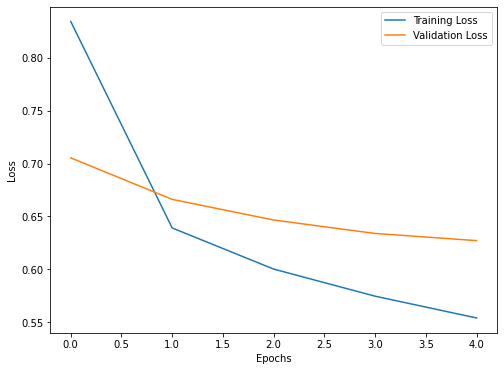

In [23]:
plt.figure(figsize=(8, 6))
plt.plot(torch.arange(epochs) , train_loss_epochs, label='Training Loss');
plt.plot(torch.arange(epochs) , val_loss_epochs, label='Validation Loss');
plt.xlabel('Epochs');
plt.ylabel('Loss');
plt.legend();

In [43]:
input_text="Hello, how are you?"
input = tokenizer.encode(input_text)
output = model.generate(input_ids=torch.tensor([input]).to(device), max_new_tokens=20, do_sample=True, temperature=1.2)
print(input_text)
print(tokenizer.decode(output[0], skip_special_tokens=True))

Hello, how are you?
Hello, how now.


In [81]:
input_text="Now, beautiful Hippolyta , the hour of our wedding is speeding closer."
input = tokenizer.encode(input_text)
output = model.generate(input_ids=torch.tensor([input]).to(device), do_sample=True, temperature=1.1)
print(input_text)
print(tokenizer.decode(output[0], skip_special_tokens=True))

Now, beautiful Hippolyta , the hour of our wedding is speeding closer.
Well, beautiful Hippolyta; the hour of our wedding stoops
